### Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing, utils, losses, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Embedding, SpatialDropout1D
import numpy as np
from pickle import dump, load
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import datetime
from geopy.geocoders import Nominatim

### Load Data & Process

In [2]:
def min_max_scale(vals):
    min_val = min(vals)
    max_val = max(vals)
    scaled_vals = []
    for val in vals:
        val = val[0]
        scaled_val = ((val - min_val) / (max_val - min_val))[0]
        scaled_vals.append(scaled_val)
    return scaled_vals

# load data
weather_dataframe = pd.read_csv('65 Years of Weather Data Bangladesh (1948 - 2013).csv')

# generate rainfall percentage using min-max scaling
rainfall_percentage = []
for val in min_max_scale(weather_dataframe[['Rainfall']].values):
    rainfall_percentage.append(round(val * 100))
weather_dataframe['Rainfall Percentage'] = rainfall_percentage

# define training data
X = np.array(weather_dataframe[['Latitude', 'Longitude', 'Year', 'Month']].values)
Y = np.array(weather_dataframe[['Min Temp', 'Max Temp', 'Rainfall', 'Relative Humidity', 'Wind Speed', 'Cloud Coverage', 'Bright Sunshine', 'Rainfall Percentage']].values)

input_dim = X.shape[1]
output_dim = Y.shape[1]
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.05)

weather_dataframe.sample(n=10)

,Station Names,Year,Month,Latitude,Longitude,Max Temp,Min Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percentage
19669,Sylhet,1969,1,24.88,91.93,27.9,11.4,12.0,71.000000,1.500000,1.6,8.600000,1.0
5420,Cox's Bazar,1974,12,21.46,91.98,28.3,15.4,0.0,72.000000,2.300000,0.1,8.800000,0.0
5882,Dhaka,2009,7,23.78,90.39,35.7,26.7,676.0,80.000000,1.700000,6.6,4.700000,33.0
1517,Bogra,1977,3,24.88,89.36,34.2,18.2,13.0,60.000000,1.200000,1.7,9.800000,1.0
16587,Rangpur,2005,9,25.72,89.26,35.6,25.9,328.0,84.000000,0.700000,5.4,6.200000,16.0
16720,Rangpur,1958,12,25.72,89.26,26.9,12.4,189.0,81.709091,0.714815,0.9,6.871429,9.0
13076,Maijdee Court,1965,11,22.83,91.08,31.3,18.7,20.0,80.000000,0.200000,0.7,7.600000,1.0
16886,Sandwip,1980,3,22.50,91.46,34.0,20.6,74.0,73.000000,1.800000,2.5,8.000000,4.0
19310,Srimangal,2010,11,24.29,91.73,33.1,17.4,1.0,82.000000,2.000000,1.5,7.400000,0.0
1707,Bogra,1969,6,24.88,89.36,35.0,25.7,207.0,86.000000,1.400000,6.1,5.700000,10.0


### Deep Learning Algorithms

In [3]:
# define and compile the model
model = Sequential()
model.add(Dense(100, input_dim=input_dim, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(output_dim))
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 3,996
Trainable params: 3,996
Non-trainable params: 0
_________________________________________________________________


In [4]:
# fit the model
history = model.fit(x_train, y_train, batch_size=25, epochs=100, validation_split = 0.3)

Epoch 1/100
562/562 [==============================] - 2s 3ms/step - loss: 7356.9302 - accuracy: 0.5493 - val_loss: 7472.9380 - val_accuracy: 0.5558
Epoch 2/100
562/562 [==============================] - 2s 4ms/step - loss: 7124.3101 - accuracy: 0.5531 - val_loss: 7404.1616 - val_accuracy: 0.5558
Epoch 3/100
562/562 [==============================] - 1s 2ms/step - loss: 7100.1016 - accuracy: 0.5531 - val_loss: 7394.5962 - val_accuracy: 0.5558
Epoch 4/100
562/562 [==============================] - 1s 2ms/step - loss: 7096.6387 - accuracy: 0.5531 - val_loss: 7429.2026 - val_accuracy: 0.5558
Epoch 5/100
562/562 [==============================] - 1s 1ms/step - loss: 7092.5288 - accuracy: 0.5531 - val_loss: 7438.2578 - val_accuracy: 0.5558
Epoch 6/100
562/562 [==============================] - 1s 2ms/step - loss: 7073.7764 - accuracy: 0.5531 - val_loss: 7443.7959 - val_accuracy: 0.5558
Epoch 7/100
562/562 [==============================] - 1s 2ms/step - loss: 7097.4604 - accuracy: 0.5531 - 

Epoch 56/100
562/562 [==============================] - 1s 2ms/step - loss: 3232.6396 - accuracy: 0.8292 - val_loss: 3405.0518 - val_accuracy: 0.7927
Epoch 57/100
562/562 [==============================] - 2s 4ms/step - loss: 3234.8408 - accuracy: 0.8317 - val_loss: 3263.0840 - val_accuracy: 0.8595
Epoch 58/100
562/562 [==============================] - 3s 5ms/step - loss: 3182.3740 - accuracy: 0.8296 - val_loss: 3208.5840 - val_accuracy: 0.8342
Epoch 59/100
562/562 [==============================] - 2s 3ms/step - loss: 3237.7385 - accuracy: 0.8248 - val_loss: 3523.7112 - val_accuracy: 0.8510
Epoch 60/100
562/562 [==============================] - 2s 4ms/step - loss: 3167.8550 - accuracy: 0.8307 - val_loss: 3332.0601 - val_accuracy: 0.8161
Epoch 61/100
562/562 [==============================] - 1s 1ms/step - loss: 3159.0815 - accuracy: 0.8300 - val_loss: 3501.9058 - val_accuracy: 0.8937
Epoch 62/100
562/562 [==============================] - 1s 2ms/step - loss: 3181.4805 - accuracy: 0.

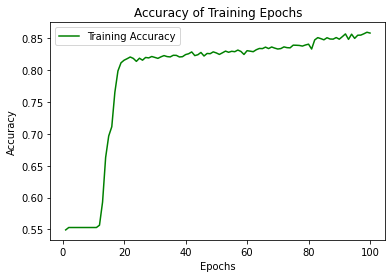

In [5]:
pyplot.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'g', label='Training Accuracy')
pyplot.title('Accuracy of Training Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [6]:
# save the trained model
model.save('model.h5')

### Load the Saved Model and Test

In [8]:
# load the model
model = keras.models.load_model('model.h5')

# bulk prediction
test_dataframe = []
for i in range(0, 20):
    test_x = x_test[i]
    test_y = y_test[i]
    pred_y = model.predict(np.array([test_x]))[0]
    test_dataframe.append([
        str(round(test_x[0], 2)), str(round(test_x[1], 2)), int(test_x[2]), int(test_x[3]),
        str(round(test_y[0], 1)), str(round(pred_y[0], 1)),
        str(round(test_y[1], 1)), str(round(pred_y[1], 1)),
        str(round(test_y[2], 1)), str(round(pred_y[2], 1)),
        str(round(test_y[3], 1)), str(round(pred_y[3], 1)),
        str(round(test_y[4], 1)), str(round(pred_y[4], 1)),
        str(round(test_y[5], 1)), str(round(pred_y[5], 1)),
        str(round(test_y[6], 1)), str(round(pred_y[6], 1)),
        str(round(test_y[7], 1)), str(round(pred_y[7], 1))
    ])

test_dataframe = pd.DataFrame(test_dataframe)
test_dataframe.columns = [
    'Latitude', 'Longitude', 'Year', 'Month',
    'Min Temp', 'Min Temp (Predicted)',
    'Max Temp', 'Max Temp (Predicted)',
    'Rainfall', 'Rainfall (Predicted)',
    'Relative Humidity', 'Relative Humidity (Predicted)',
    'Wind Speed', 'Wind Speed (Predicted)',
    'Cloud Coverage', 'Cloud Coverage (Predicted)',
    'Bright Sunshine', 'Bright Sunshine (Predicted)',
    'Rainfall Percentage', 'Rainfall Percentage (Predicted)'
]

def dataframe_style(data):
    return ['background-color: rgba(0, 0, 0, 0.25);' for i in data]
test_dataframe.style.apply(dataframe_style, axis=0, subset=[
    'Min Temp', 'Min Temp (Predicted)',
    'Rainfall', 'Rainfall (Predicted)',
    'Wind Speed', 'Wind Speed (Predicted)',
    'Bright Sunshine', 'Bright Sunshine (Predicted)'
])

,Latitude,Longitude,Year,Month,Min Temp,Min Temp (Predicted),Max Temp,Max Temp (Predicted),Rainfall,Rainfall (Predicted),Relative Humidity,Relative Humidity (Predicted),Wind Speed,Wind Speed (Predicted),Cloud Coverage,Cloud Coverage (Predicted),Bright Sunshine,Bright Sunshine (Predicted),Rainfall Percentage,Rainfall Percentage (Predicted)
0,23.17,90.18,2013,10,24.0,22.2,34.7,33.0,200.0,228.4,86.0,82.6,0.3,0.8,4.6,2.9,5.1,6.6,10.0,11.2
1,23.48,91.19,1991,7,25.4,25.6,34.6,34.4,394.0,545.1,89.0,91.6,2.4,1.6,6.5,6.2,4.1,3.5,19.0,26.2
2,25.75,88.92,2005,9,26.1,22.8,36.8,33.1,158.0,266.2,82.0,82.2,1.3,0.6,4.5,3.8,6.3,5.5,8.0,12.8
3,25.75,88.92,1994,7,26.3,22.3,35.2,32.6,448.9,443.4,75.0,89.0,2.6,0.8,5.3,5.3,4.5,2.9,22.0,20.9
4,23.61,89.84,2008,5,24.6,23.0,37.6,34.8,58.0,240.6,75.0,75.2,0.9,1.4,3.3,3.6,8.1,7.0,3.0,12.4
5,22.34,91.79,1987,2,16.6,16.3,32.0,33.8,20.0,31.0,71.0,75.3,1.3,0.5,1.4,2.0,8.6,7.1,1.0,1.5
6,24.29,91.73,1992,5,22.0,23.7,36.4,35.3,354.0,256.5,80.0,75.9,0.4,1.6,4.2,3.8,6.9,6.9,17.0,13.1
7,23.78,90.39,1966,4,24.3,21.8,37.6,35.9,34.0,97.3,71.0,70.6,3.8,1.4,3.3,2.8,9.2,7.7,2.0,5.3
8,24.35,88.56,2010,8,26.6,23.2,37.8,33.3,101.0,387.0,84.0,87.3,2.4,0.8,5.3,4.9,5.6,4.2,5.0,18.4
9,23.61,89.84,1993,12,14.7,15.1,28.6,28.2,0.0,19.7,77.0,77.9,0.4,0.0,0.9,-0.2,8.1,8.1,0.0,1.5


In [9]:
y_pred = model.predict(x_test)
print("Explain variance score =", metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score =", metrics.r2_score(y_test, y_pred))

Explain variance score = 0.585149316356258
R2 score = 0.5503879037151351


### Load the Current Location and Predict Weather of Next 12 Months

In [10]:
%%javascript
// load latitude, longitude of current location
navigator.geolocation.getCurrentPosition(currentPosition => {
    IPython.notebook.kernel.execute(`
        current_position = {
            'latitude': ${currentPosition.coords.latitude},
            'longitude': ${currentPosition.coords.longitude}
        }
    `)
})

<IPython.core.display.Javascript object>

In [12]:
# bulk prediction
result_dataframe = []
for i in range(0, 12):
    month = datetime.datetime.now().month + i
    year = datetime.datetime.now().year
    if month > 12:
        month = month - 12
        year = year + 1
        
    pred = model.predict(np.array([[
        current_position['latitude'],
        current_position['longitude'],
        year,
        month
    ]]))[0]
    result_dataframe.append([str(month) + '/' + str(year), pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7]])
    
result_dataframe = pd.DataFrame(result_dataframe)
result_dataframe.columns = [
    'Month',
    'Min Temp',
    'Max Temp',
    'Rainfall',
    'Relative Humidity',
    'Wind Speed',
    'Cloud Coverage',
    'Bright Sunshine',
    'Rainfall Percenatge'
]

location = Nominatim(user_agent="Weather Forecasting").reverse(str(current_position['latitude']) + ', ' + str(current_position['longitude']))
print('Weather Forecasting for:\nLocation: ' + location.address + '\nLatitude: ' + str(current_position['latitude']) + '\nLongitude: ' + str(current_position['longitude']))
result_dataframe

Weather Forecasting for:
Location: দক্ষিণ বাড্ডা, গুলশান, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, 1212, Bangladesh
Latitude: 23.7746161
Longitude: 90.4237766


,Month,Min Temp,Max Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percenatge
0,9/2020,24.732584,34.315975,342.663818,85.396889,1.063010,4.416922,5.772417,16.635544
1,10/2020,22.085981,33.037174,219.785629,82.471825,0.713607,2.839964,6.583487,10.759654
2,11/2020,19.083735,31.226061,114.468895,80.346558,0.355521,1.371481,7.327623,5.799601
3,12/2020,15.667501,28.790085,28.878750,79.071159,-0.004674,-0.022096,8.032381,1.920536
4,1/2021,12.179491,30.932531,-24.617832,74.178940,-0.104134,0.775229,7.187902,-0.898067
5,2/2021,15.316011,32.699070,12.984066,73.427002,0.377555,1.371413,7.421534,1.059125
6,3/2021,18.452528,34.465603,50.586163,72.675026,0.859283,1.967566,7.655199,3.016345
7,4/2021,21.450701,36.156540,88.687393,72.095909,1.321555,2.652396,7.776495,4.854928
8,5/2021,23.140978,35.047276,235.973267,75.486336,1.416518,3.627036,7.119074,12.205550
9,6/2021,25.531092,35.938084,396.799225,83.887131,1.229644,5.190596,5.447969,19.081207


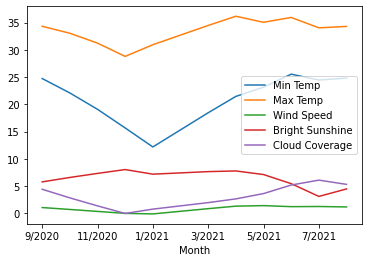

In [13]:
# plot data
ax = pyplot.gca()
result_dataframe.plot(kind='line', x='Month', y='Min Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Max Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Wind Speed', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Bright Sunshine', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Cloud Coverage', ax=ax)
pyplot.show()